# Dragging gestures: Analysis

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
funcIoDs = json.loads('{"0":{"0":"6.283185307179473","1":"7.684979129553419","2":"15.106674542430683","3":"19.347928253780562","4":"29.956847626323636","5":"25.404852897676147"},"1":{"0":"7.125365375765129","1":"6.283185307179473","2":"16.54678526844666","3":"18.287200001083097","4":"28.15186551422996","5":"27.56328436235389"},"2":{"0":"9.53404123917492","1":"9.6008773144739","2":"16.29614028281385","3":"18.300879392026552","4":"28.915435394880227","5":"29.47163833074686"},"3":{"0":"9.773843811168225","1":"9.800935246846214","2":"17.21052221331437","3":"19.53487409914851","4":"27.29772910106571","5":"30.079752067446435"}}')

In [3]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodsAsArray(projections, experimentModes):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            test = 0
            if projection == 'Cartesian' and experimentMode == 1:
                test = 1
            elif projection == 'Polar' and experimentMode == 0:
                test = 2
            elif projection == 'Polar' and experimentMode == 1:
                test = 3
    
            # iod = index of difficulty
            iods = funcIoDs[str(test)]
    
            for iod in iods:
                iodsArr.append(float(iods[iod]))
    return iodsArr

Columns: Index(['Participant name', 'Participant age', 'Device', 'Test mode',
       'Logging timestamp', 'Function ID', 'Function difficulty',
       'Function projection', 'Drawing time', 'Error approx', 'Is Left handed',
       'Experienced Graphic Tablet User'],
      dtype='object')


## Participant data

Number of participants: 9
Average participant age: 23.111

 ::::
Number of left handed participants: 1
Percentage of left handed participants 0.111 %

 ::::
Number of expert graphic tablet participants: 2
Percentage of expert graphic tablet participants 0.222 %


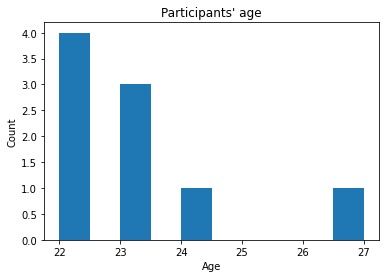

In [4]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
leftHanded = 0
hasExpWTablet = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    leftHanded += row['Is Left handed'].values[0]
    hasExpWTablet += row['Experienced Graphic Tablet User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages)
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))

print("\n ::::")
print("Number of left handed participants:", leftHanded)
print("Percentage of left handed participants", round(leftHanded * 1.0 / len(participants), 3), '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3), '%'
    )


# Average drawing time for each curve on each input device

In [5]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0):
    # filter out by projection, Cartesian or Polar
    drawingTimes = df[df['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    drawingTimes = drawingTimes['Drawing time'].values
    
    dtSum = 0.0
    
    for dt in drawingTimes:
        dtSum += dt
    
    avg = dtSum * 1.0 / len(drawingTimes)
    
    return avg

def getAvgsByFilter(projections, funcIds, devices, experimentModes):
    times = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode)
                    times.append(avg)
    return times

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [6]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in devices:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, 50])
            plt.xlim([0, 31])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            plt.show()

## Test plots

In [7]:
# plotForExperiment([0, 1])

# Linear regression

In [34]:
def getDataForRegression(projections, experimentModes, device):
    iods = getIodsAsArray(projections, experimentModes)
    x = [[iod] for iod in iods]

    y = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    return x, y

def getRegressionModel(projections, experimentModes, device):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    validateRegressionModel(reg, projections, experimentModes, device)

    return reg

def validateRegressionModel(reg, projections, experimentModes, device):  
    x, y = getDataForRegression(projections, experimentModes, device)  

    plt.figure()
    plt.scatter(x, y, label="Experiment data")

    predictX = np.linspace(1, 30, 10)
    predictY = reg.predict([[x] for x in predictX])
    plt.plot(predictX, predictY, color="black", label="Linear regression")
    
    plt.ylabel("Drawing time (s)")
    plt.xlabel("Index of difficulty")
    plt.ylim([0, 50])
    plt.xlim([0, 31])
    plt.legend(loc='upper left')
    plt.title("Linear regression for %s, %s" %(projections, device))
    plt.show()
    
    print("R^2 =", reg.score(x, y))


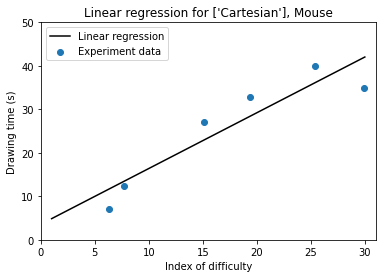

R^2 = 0.856823666364535


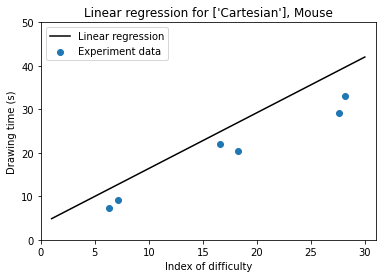

R^2 = 0.5784611393229744


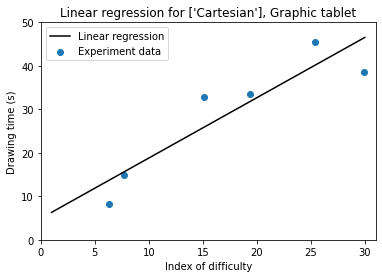

R^2 = 0.8348223791519057


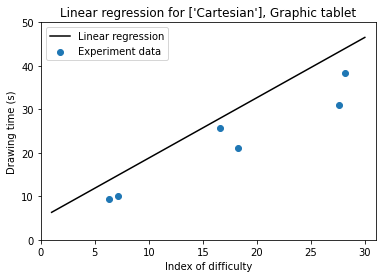

R^2 = 0.5378498307244912


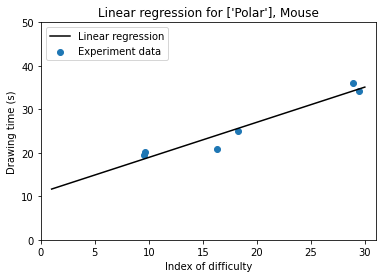

R^2 = 0.9390596203976331


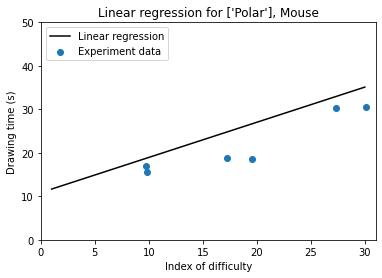

R^2 = 0.3775186352050057


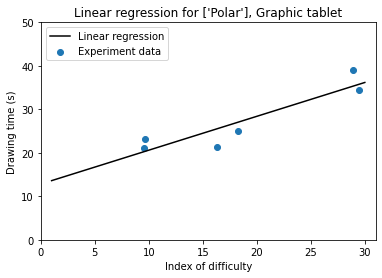

R^2 = 0.8408833055905733


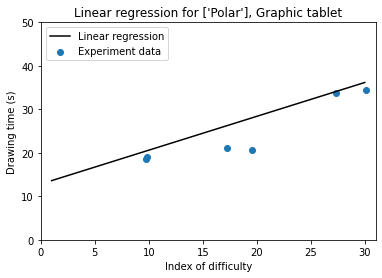

R^2 = 0.6768331030483195


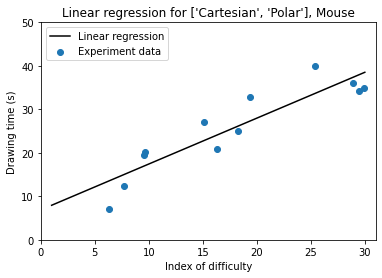

R^2 = 0.8311460474800016


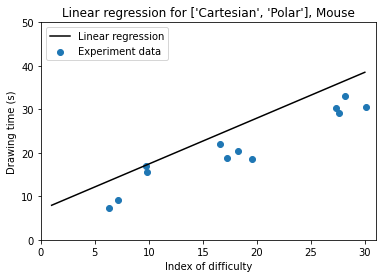

R^2 = 0.5066300524907696


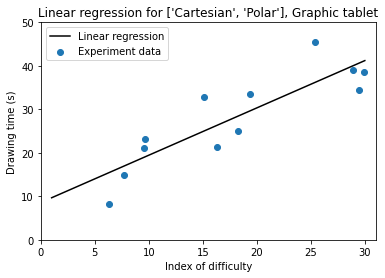

R^2 = 0.7570599286381783


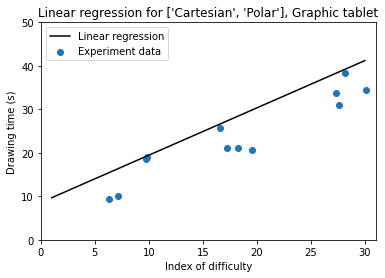

R^2 = 0.6056889985843836


In [35]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        reg = getRegressionModel(projections, [0], device)
        validateRegressionModel(reg, projections, [1], device)
